In [1]:
import sys

import networkx as nx

sys.path.append('../')

In [2]:
import numpy as np

from vrp_study.data_model import Tariff, Cargo, Node
from vrp_study.data_model import TariffCost
from vrp_study.routing_manager import PDRoutingManager
from vrp_study.ortools_routing_model.routing_model import find_optimal_paths

In [3]:
import lkh

In [4]:
name = 'lc101.pdptw'

In [5]:
with open(f'../data/lkh_vrppdtw_ex/PDPTW/INSTANCES/Li/{name}', 'r', encoding='utf-8') as file:
    problem_str = ''.join([l for l in file.read()])

In [6]:
problem = lkh.LKHProblem.parse(problem_str)
problem.vehicles = 100

In [7]:
# solver_path = '../lkh/LKH-3.0.13/LKH'
# sol = lkh.solve(solver_path, problem=problem, max_trials=100, runs=10)
# g = problem.get_graph()
# l = 0
# for s in sol:
#     l += sum(g.edges()[s[i], s[i + 1]]['weight'] for i in range(len(s) - 1)) + g.edges()[1, s[0]]['weight'] + \
#          g.edges()[s[-1], 1]['weight']
# len(sol),l

In [8]:
data = problem.as_name_dict()

In [9]:
tariff = Tariff(
    id='car',
    capacity=int(data['capacity']),
    max_count=int(data['vehicles']),
    cost_per_distance=[TariffCost(
        min_dst_km=0,
        max_dst_km=float('inf'),
        cost_per_km=1,
        fixed_cost=0
    )]
)

In [10]:
nodes: list[Node] = []
for d in data['pickup_and_delivery_section']:
    nodes.append(
        Node(
            id=d[0],
            cargo_id=-1,
            capacity=d[1],
            service_time=d[4],
            start_time=d[2],
            end_time=d[3],
            coordinates=data['node_coords'][d[0]]
        )
    )
depo = nodes[0]

In [11]:
cargos: list[Cargo] = []
for d in data['pickup_and_delivery_section'][1:]:
    if d[1] <= 0:
        continue
    cargos.append(Cargo(
        id=len(cargos),
        nodes=[nodes[d[0] - 1], nodes[d[-1] - 1]]
    ))

In [12]:
len(cargos)

53

In [13]:
p2coordinates = {}
p2coordinates.update({
    crg.nodes[i].id: crg.nodes[i].coordinates for crg in cargos for i in range(2)
})
p2coordinates[depo.id] = depo.coordinates
distance_matrix = {(u, v): np.sqrt((du[0] - dv[0]) ** 2 + (du[1] - dv[1]) ** 2) for u, du in
                   p2coordinates.items() for
                   v, dv in p2coordinates.items()}
time_matrix = {(u, v): np.sqrt((du[0] - dv[0]) ** 2 + (du[1] - dv[1]) ** 2) for u, du in p2coordinates.items() for
               v, dv in p2coordinates.items()}

In [17]:

routing_manager = PDRoutingManager()

routing_manager.add_cargos(cargos)
routing_manager.add_tariff(tariff)

routing_manager.add_depo(depo)

routing_manager.distance_matrix = distance_matrix
routing_manager.time_matrix = time_matrix

routing_manager.max_time_minutes = 0.5

routing_manager.build()

In [54]:
sol = find_optimal_paths(routing_manager)

2025-06-23 18:25:36.360 | INFO     | vrp_study.ortools_routing_model.routing_model:find_optimal_paths:553 - problem size: 211
2025-06-23 18:25:36.361 | INFO     | vrp_study.ortools_routing_model.routing_model:create_model:539 - Начало создания модели
2025-06-23 18:25:36.363 | INFO     | vrp_study.ortools_routing_model.routing_model:add_distance_dimension:400 - Добавление размерности для расстояния
2025-06-23 18:25:36.364 | INFO     | vrp_study.ortools_routing_model.routing_model:add_pick_up_and_delivery:369 - Добавление ограничения для порядка доставки
2025-06-23 18:25:36.366 | INFO     | vrp_study.ortools_routing_model.routing_model:add_time_window:288 - add time
2025-06-23 18:25:36.368 | INFO     | vrp_study.ortools_routing_model.routing_model:add_mass_constraint:271 - Добавление ограничений для массы
2025-06-23 18:25:36.369 | INFO     | vrp_study.ortools_routing_model.routing_model:add_fixed_vehicles_cost:352 - Добавление стоимостей машин
2025-06-23 18:25:36.379 | INFO     | vrp_stu

In [55]:
total_l = 0
total_car = 0
for s in sol[0]:
    if len(s) > 0:
        # print(s)
        l = sum(routing_manager.get_distance(s[i], s[i + 1]) for i in range(len(s) - 1))
        # print(s, l)
        total_l += l
        total_car += 1
total_car, total_l

(20, 2913.854044506088)

In [56]:
for crg in cargos:
    in1 = routing_manager._node_to_inner_node[crg.nodes[0]]
    in2 = routing_manager._node_to_inner_node[crg.nodes[1]]

    start = None
    end = None
    in_time = None
    out_time = None

    for i, s in enumerate(sol[0]):
        s_time = sol[1][i]
        if len(s) == 0:
            continue

        for order, i in enumerate(s):
            if i == in1.id:
                start = i
                in_time = s_time[order]
            if i == in2.id:
                end = i
                out_time = s_time[order]

    assert start is not None and end is not None and start < end, (start, end)

    if not (crg.nodes[0].start_time <= in_time[0] and crg.nodes[0].end_time >= in_time[1]):
        print(in_time, crg.nodes[0].start_time, crg.nodes[0].end_time)
    if not (crg.nodes[1].start_time <= out_time[0] and crg.nodes[1].end_time >= out_time[1]):
        print(out_time, crg.nodes[0].start_time, crg.nodes[0].end_time)

In [61]:
import networkx as nx

g = nx.Graph()
for node in nodes:
    color = 'green' if node.id == 1 else 'red' if node.capacity < 0 else 'blue'
    g.add_node(node.id, x=node.coordinates[0], y=node.coordinates[1], coords=node.coordinates, color=color)
for r in sol[0]:
    if len(r) > 0:
        for i in range(1, len(r) - 2):
            n1 = routing_manager.nodes()[r[i]].routing_node
            n2 = routing_manager.nodes()[r[i + 1]].routing_node
            g.add_edge(n1.id, n2.id)
    # print(r)

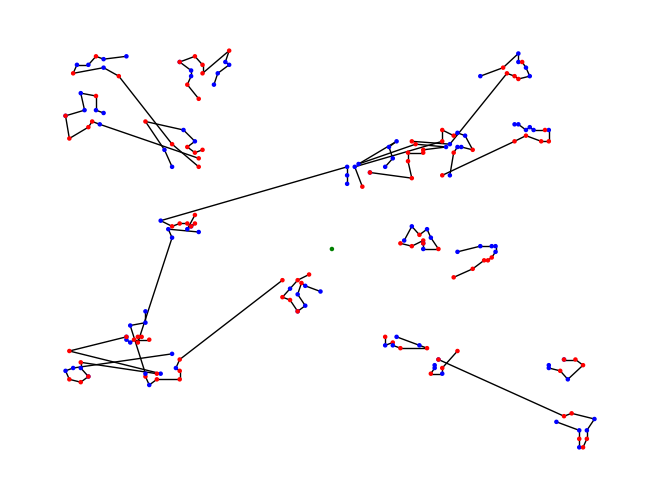

In [62]:
nx.draw(g, pos={u: d for u, d in g.nodes(data='coords')}, node_color=[d for _, d in g.nodes(data='color')], node_size=5)

In [59]:
from vrp_study.routing_manager import RoutingManager, PDRoutingManager
from ortools.sat.python import cp_model
from loguru import logger as log
from tqdm.auto import tqdm, trange

best = {'preferred_variable_order': 2,
        'clause_cleanup_protection': 1,
        'max_presolve_iterations': 5,
        'cp_model_probing_level': 1,
        'presolve_probing_deterministic_time_limit': 10.0,
        'search_branching': 2,
        'feasibility_jump_linearization_level': 0,
        'fp_rounding': 0,
        'polish_lp_solution': True,
        'linearization_level': 0,
        'cut_level': 2,
        'max_all_diff_cut_size': 128,
        'symmetry_level': 0,
        'num_workers': 8}


# 
# class CpROutingModel:
#     def __init__(self):
#         self.X = {}

def get_solver():
    solver = cp_model.CpSolver()

    for k, v in best.items():
        if isinstance(v, list):
            for ss in v:
                solver.parameters.ignore_subsolvers.append(ss)
        else:
            if 'ignore_subsolvers' in k:
                if v:
                    solver.parameters.ignore_subsolvers.append(k.split(':')[1])
            else:
                exec(f'solver.parameters.{k} = {v}')

    solver.parameters.log_search_progress = True
    solver.parameters.max_time_in_seconds = 60.0 * 30
    return solver


def find_optimal_paths(
        routing_manager: PDRoutingManager,
):
    log.info(f'problem size: {len(routing_manager.nodes())}')

    N = len(routing_manager.nodes())
    P = len(routing_manager.cars())
    M = 1_000_000

    X = {}
    T = {}
    Q = {}

    model = cp_model.CpModel()

    for p in trange(P, leave=False, desc='create_X_{p,i,j}'):
        for i in range(N):
            for j in range(N):
                if i == j:
                    X[p, i, j] = model.new_constant(0)
                else:
                    X[p, i, j] = model.new_bool_var(f'x_{p, i, j}')

    max_time = max(n.late_time for n in routing_manager.nodes())
    max_mass = max(car.capacity for car in routing_manager.cars())

    log.debug(f'max_time: {max_time}, max_mass: {max_mass}')
    for i in range(N):
        T[i] = model.new_int_var(lb=0, ub=max_time, name=f'time_{i}')
        Q[i] = model.new_int_var(lb=0, ub=max_mass, name=f'mass_{i}')

    for p, car in enumerate(routing_manager.cars()):
        model.add(sum(X[p, i, car.start_node.id] for i in range(N)) == 0)
        model.add(sum(X[p, car.end_node.id, i] for i in range(N)) == 0)

        model.add(sum(X[p, car.start_node.id, i] for i in range(N)) == 1)
        model.add(sum(X[p, i, car.end_node.id] for i in range(N)) == 1)

    for i, node in enumerate(routing_manager.nodes()):
        for p, car in enumerate(routing_manager.cars()):
            if car.start_node.id != node.id and car.end_node.id != node.id:
                model.add(
                    sum(X[p, i, j] for j in range(N)) == sum(X[p, j, i] for j in range(N))
                )

            for j in range(N):
                if i == j:
                    continue
                # log.debug(f'time_{i,j}:{routing_manager.get_time(i,j)} ')
                model.add(
                    T[i] + int(routing_manager.get_time(i, j) + routing_manager.nodes()[i].service_time) <=
                    T[j] + M * (1 - X[p, i, j]))
                
                model.add(
                    Q[i] + routing_manager.nodes()[i].demand <=
                    Q[j] + M * (1 - X[p, i, j]))
                
                
        if node.is_transit:
            model.add(
                sum(X[p, j, i] for p in range(P) for j in range(N)) == 1
            )

    for node_a, node_b in routing_manager.get_pick_up_and_delivery_nodes():
        a, b = node_a.id, node_b.id
        model.add(T[a] <= T[b])
        for p in range(P):
            model.add(sum(X[p, k, a] + X[p, k, b] for k in range(N)) == 2 * sum(X[p, k, a] for k in range(N)))

    for i, node in enumerate(routing_manager.nodes()):
        model.add(node.early_time <= T[i])
        model.add(T[i] <= node.late_time)

    
    obj = sum(X[p,i,j] * int(routing_manager.get_distance(i,j)) for p in range(P) for i in range(N) for j in range(N))
    model.minimize(obj)

    solver = get_solver()
    status = solver.solve(model)
    log.info(f'status: {status}')

    for p in range(P):
        for k, v in X.items():
            if k[0] == p and solver.value(v) == 1 and k != (p, 0, 1):
                print(k)
    
    # todo тут я осознал что это уже не имеет смысла, тк в задаче на сто грузов уже 1.3 млн переменных.

In [60]:
routing_manager = PDRoutingManager()

routing_manager.add_cargos(cargos[:3])
routing_manager.add_tariff(tariff)

routing_manager.add_depo(depo)

routing_manager.distance_matrix = distance_matrix
routing_manager.time_matrix = time_matrix

routing_manager.max_time_minutes = 0.5

routing_manager.build()

In [61]:
find_optimal_paths(routing_manager)

2025-06-24 11:14:37.033 | INFO     | __main__:find_optimal_paths:49 - problem size: 8


create_X_{p,i,j}:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-24 11:14:37.127 | DEBUG    | __main__:find_optimal_paths:72 - max_time: 1236, max_mass: 200



Starting CP-SAT solver v9.14.6206
Parameters: preferred_variable_order: IN_RANDOM_ORDER max_time_in_seconds: 1800 log_search_progress: true presolve_probing_deterministic_time_limit: 10 clause_cleanup_protection: PROTECTION_ALWAYS search_branching: PORTFOLIO_SEARCH linearization_level: 0 cp_model_probing_level: 1 max_presolve_iterations: 5 max_all_diff_cut_size: 128 fp_rounding: NEAREST_INTEGER polish_lp_solution: true symmetry_level: 0 cut_level: 2 num_workers: 8 feasibility_jump_linearization_level: 0

Initial optimization model '': (model_fingerprint: 0x47992fea0b4aeff6)
#Variables: 5'617 (#bools: 5'400 in objective) (4'715 primary variables)
  - 5'600 Booleans in [0,1]
  - 8 in [0,200]
  - 8 in [0,1236]
  - 1 constants in {0} 
#kLinear1: 16
#kLinear2: 3
#kLinear3: 11'200
#kLinearN: 1'306 (#terms: 20'006)

Starting presolve at 0.02s
  2.19e-03s  0.00e+00d  [DetectDominanceRelations] 
  1.01e-01s  0.00e+00d  [PresolveToFixPoint] #num_loops=10 #num_dual_strengthening=6 
  3.87e-04s  

2025-06-24 11:14:39.039 | INFO     | __main__:find_optimal_paths:125 - status: 4


  8.15e-04s  0.00e+00d  [DetectDuplicateConstraintsWithDifferentEnforcements] 
  1.87e-01s  1.97e-01d  [Probe] #probed=3'200 #new_binary_clauses=41'600 
  1.45e-04s  0.00e+00d  [MaxClique] 
  1.27e-03s  0.00e+00d  [DetectDominanceRelations] 
  3.68e-03s  0.00e+00d  [PresolveToFixPoint] #num_loops=1 #num_dual_strengthening=1 
  7.55e-04s  0.00e+00d  [ProcessAtMostOneAndLinear] 
  5.56e-04s  0.00e+00d  [DetectDuplicateConstraints] 
  5.24e-04s  0.00e+00d  [DetectDuplicateConstraintsWithDifferentEnforcements] 
  1.60e-04s  3.00e-06d  [DetectDominatedLinearConstraints] #relevant_constraints=200 
  7.62e-05s  0.00e+00d  [DetectDifferentVariables] 
  6.10e-04s  1.25e-05d  [ProcessSetPPC] #relevant_constraints=806 
  1.36e-04s  1.90e-06d  [FindAlmostIdenticalLinearConstraints] #num_tested_pairs=76 
  3.84e-03s  2.85e-03d  [FindBigAtMostOneAndLinearOverlap] 
  2.06e-04s  5.05e-05d  [FindBigVerticalLinearOverlap] 
  1.46e-04s  5.00e-06d  [FindBigHorizontalLinearOverlap] #linears=200 
  1.52e-04

In [62]:
for crg in cargos[:5]:
    print(crg.nodes[0].id, '->', crg.nodes[1].id)

4 -> 76
6 -> 8
7 -> 3
9 -> 11
10 -> 5


In [63]:
a, b = 6, 7
routing_manager.nodes()[a].routing_node.id, routing_manager.nodes()[b].routing_node.id

(7, 3)